# <h1><center> MLB Attendance Exploration & Prediction </center></h1>

One of the core functions of an analytics team in Major League Baseball (MLB) is to accurately predict game attendance to help the MLB and its teams budget and staff appropriately. Understanding the drivers of attendance can help these organizations optimize sales, advertising, and promotional efforts.

**The goal of this project was to examine MLB game attendance to understand factors that may affect it and predict future game attendance using machine learning.** Data for this project came from a Kaggle dataset called MLB Game Data (https://www.kaggle.com/datasets/josephvm/mlb-game-data/data). The dataset included information -- including home and away teams, game date and time, and attendance -- for individual MLB games between 2016 and 2021.

## <span style="color:blue">Data cleaning & pre-processing</span>

#### Import Important libraries and dataset
The important libraries for this project were pandas and numpy. I read in the MLB Game Data from Kaggle as a .csv file.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np

In [2]:
# import relevant files
# dataset from on kaggle (https://www.kaggle.com/datasets/josephvm/mlb-game-data/data)
dataframe = pd.read_csv("mlb_games.csv")

#### Filter the dataset for important variables
For this project, the variables I focused on for each game were the home and away teams, date (from which I could get data on time of day, day of the week, month, and year), and attendance.

In [3]:
# filter the dataframe for important variables
df = dataframe[['away', 'home', 'Date', 'Attendance']]

# make column names lowercase
df.columns = df.columns.str.lower()

In [4]:
# review dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13439 entries, 0 to 13438
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   away        13439 non-null  object
 1   home        13439 non-null  object
 2   date        13439 non-null  object
 3   attendance  12416 non-null  object
dtypes: object(4)
memory usage: 420.1+ KB


#### Dropping rows with missing attendance data
Attendance was the target variable of my analysis so any games that did not have attendance data were dropped from the dataset. There were 1,023 of 13,439 games missing attendance data.

In [5]:
# dropping all rows with with missing attendance data
df = df.dropna(subset=['attendance'])

In [6]:
# review games dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12416 entries, 0 to 13438
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   away        12416 non-null  object
 1   home        12416 non-null  object
 2   date        12416 non-null  object
 3   attendance  12416 non-null  object
dtypes: object(4)
memory usage: 485.0+ KB


#### Data validation
I wanted to make sure that there were 30 teams in both the away and home columns of the dataset and that there was no team in the home column that wasn't in the away column. I found that all-star games were included in the dataset, so I dropped these games.

In [7]:
# check to see if the list of away teams matches that of the home teams

# check away column for more than 30 teams
away_num = len(df['away'].unique())
away_teams = sorted(df['away'].unique())

line_break = '\n\n'

# check home column for more than 30 teams
home_num = len(df['home'].unique())
home_teams = sorted(df['home'].unique())

print(f'away_teams: {away_num}; {away_teams} {line_break} home_teams: {home_num}; {home_teams}')

away_teams: 32; ['AL', 'ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NL', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX', 'TOR', 'WSH'] 

 home_teams: 32; ['AL', 'ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NL', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX', 'TOR', 'WSH']


In [8]:
# dropping all rows with with all-star games (AL, NL)
df = df[df['away'] != 'AL']
df = df[df['away'] != 'NL']
df = df[df['home'] != 'AL']
df = df[df['home'] != 'NL']

In [9]:
# make sure that there are only 30 teams in both home and away columns
away_num = len(df['away'].unique())
away_teams = sorted(df['away'].unique())

line_break = '\n\n'

home_num = len(df['home'].unique())
home_teams = sorted(df['home'].unique())

print(f'away_teams: {away_num}; {away_teams} {line_break} home_teams: {home_num}; {home_teams}')

away_teams: 30; ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX', 'TOR', 'WSH'] 

 home_teams: 30; ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX', 'TOR', 'WSH']


#### Formatting the time column
I found that the datetime ("date") column was in UTC. I wanted local datetime for each game instead. Thus, I converted each datetime from UTC to local game datetime. From there, I was able to obtain accurate year, month, day of the week, and time for each game. The hour of the game allowed me to infer the time of day (day vs. night) that each game took place -- games 6pm (17:00) and after were night games and all others were day games.

In [10]:
# import relevant timezone library
import pytz

# create a dictionary to of teams and their time zones
team_timezones = {"ARI": 'America/Phoenix', "ATL": "US/Eastern", "BAL": "US/Eastern", "BOS": "US/Eastern", "CHC": "US/Central",
                  "CHW": "US/Central", "CIN": "US/Eastern", "CLE": "US/Eastern", "COL": "US/Mountain", "DET": "US/Eastern",
                  "HOU": "US/Central", "KC": "US/Central", "LAA": "US/Pacific",  "LAD": "US/Pacific", "MIA": "US/Eastern", 
                  "MIL": "US/Central", "MIN": "US/Central", "NYM": "US/Eastern", "NYY": "US/Eastern", "OAK": "US/Pacific",
                  "PHI": "US/Eastern", "PIT": "US/Eastern", "SD": "US/Pacific", "SEA": "US/Pacific", "SF": "US/Pacific",  
                  "STL": "US/Central", "TB": "US/Eastern", "TEX": "US/Central", "TOR": "US/Eastern", "WSH": "US/Eastern"}

# convert the date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%MZ')

# create function to convert to the local time based on the home team's tz
def convert_time(row):
    team_tz = team_timezones.get(row['home']) # get the tz for each team from the above library
    local_tz = pytz.timezone(team_tz) # definte the tz for each team using pytz 
    local_time = row['date'].tz_localize('UTC').tz_convert(local_tz) # covert each team's tz from utc to the local time
    return local_time.strftime('%Y-%m-%d %I:%M %p') # covert the local time to 12-hour format

# apply function to dataframe
df['local_time'] = df.apply(convert_time, axis=1)

In [11]:
# convert local time column to datetime format
df['local_time'] = pd.to_datetime(df['local_time'])

# extract day of the week, month, year, and hour from local time column
df['day_of_week'] = df['local_time'].dt.day_name()
df['month'] = df['local_time'].dt.month_name()
df['year'] = df['local_time'].dt.year
df['hour'] = df['local_time'].dt.hour

# create a new date only column from the local time column
df['date'] = df['local_time'].dt.date

In [12]:
# review the hours of the local time of games
sorted(df['hour'].unique())

[2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [13]:
# create time of day column (day vs night) based on local time of game
df['time_of_day'] = df['hour'].apply(lambda x: 'Night' if x >= 17 else 'Day')

#### Dropping pandemic year games
Games held during the 2020 COVID-19 pandemic were likely to have outlier attendance figures so these games were dropped from the dataset.

In [14]:
# drop all games in 2020
df = df[df['year'] != 2020]

#### Further data pre-processing
I changed the names of the baseball teams to be more intuitive. I also made the column names for the home and away teams more intuitive by calling them home_team and opponent, respectively. Then I made the attendance column numeric so it could be used in data analysis.

In [15]:
# change the names of the teams
mlb_teams = {'ARI': 'Diamondbacks', 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 'CIN': 'Reds',
             'CLE': 'Guardians', 'COL': 'Rockies', 'CHW': 'White Sox', 'DET': 'Tigers', 'HOU': 'Astros', 'KC':  'Royals',
             'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers', 'MIN': 'Twins', 'NYM': 'Mets', 
             'NYY': 'Yankees', 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SD':  'Padres', 'SEA': 'Mariners',
             'SF':  'Giants', 'STL': 'Cardinals', 'TB':  'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSH': 'Nationals'}

df['opponent'] = df['away'].replace(mlb_teams) # change the name of the column away to opponent
df['home_team'] = df['home'].replace(mlb_teams) # change the name of the column away to opponent

In [16]:
# making the attendance column numeric
df['attendance'] = df['attendance'].str.replace(",", "")
df['attendance'] = df['attendance'].astype(int)

#### Final dataset
The final dataset includes only relevant variables for this project.

In [17]:
# keep only relevant columns
df = df[['home_team', 'opponent', 'date', 'year', 'month', 'day_of_week', 'time_of_day', 'attendance']]

# review dataframe
df

,home_team,opponent,date,year,month,day_of_week,time_of_day,attendance
0,Pirates,Cardinals,2016-04-03,2016,April,Sunday,Day,39500
1,Rays,Blue Jays,2016-04-03,2016,April,Sunday,Day,31042
2,Royals,Mets,2016-04-03,2016,April,Sunday,Night,40030
3,Brewers,Giants,2016-04-04,2016,April,Monday,Day,44318
4,Orioles,Twins,2016-04-04,2016,April,Monday,Day,45785
...,...,...,...,...,...,...,...,...
13434,Astros,Braves,2021-10-27,2021,October,Wednesday,Night,42833
13435,Braves,Astros,2021-10-29,2021,October,Friday,Night,42898
13436,Braves,Astros,2021-10-30,2021,October,Saturday,Night,43125
13437,Braves,Astros,2021-10-31,2021,October,Sunday,Night,43122


## <span style="color:blue">Exploratory Data Analysis</span>

#### General summary statistics
I ran some basic descriptive statistics on the attendance column. *Average attendance* in the dataset was around **27,404**; the *minimum attendance* was **1,107**; and the *maximum attendance* was **59,659**.

In [18]:
# summary statistics of attendance
df['attendance'].describe()

count    12398.000000
mean     27404.294644
std      11526.938904
min       1107.000000
25%      18415.000000
50%      27370.000000
75%      36887.000000
max      59659.000000
Name: attendance, dtype: float64

#### Which games correspond with the maximum and minimum attendance?

In [19]:
# which games correspond with the maximum and minimum attedance
max_attendance = df['attendance'].max()
min_attendance = df['attendance'].min()

df[(df['attendance'] == max_attendance) | (df['attendance'] == min_attendance)]

,home_team,opponent,date,year,month,day_of_week,time_of_day,attendance
8767,Red Sox,Yankees,2019-06-29,2019,June,Saturday,Day,59659
11551,Blue Jays,Phillies,2021-05-16,2021,May,Sunday,Day,1107


**The Red Sox home game against the Yankees on Saturday June 29, 2019 garnered the maximum attendance in this datset.** This makes sense since this is a game between rivals. Further research also showed that the game took place in London, England at the London Stadium, which has a capacity of approximately 62,500. It may be also be the case that international games draw large crowds.

**The Blue Jays home game against the Phillies on Sunday May 16, 2021 garnered the least attendance in this datset.** This may be explained by social distancing measures implemented in public spaces as a result of the COVID-19 pandemic.

#### Which games drew the largest and smalles crowds?

In [20]:
# top 10 attended attended games
df.sort_values(by='attendance', ascending = False).head(10)

,home_team,opponent,date,year,month,day_of_week,time_of_day,attendance
8767,Red Sox,Yankees,2019-06-29,2019,June,Saturday,Day,59659
8782,Red Sox,Yankees,2019-06-30,2019,June,Sunday,Day,59059
6441,Athletics,Giants,2018-07-21,2018,July,Saturday,Night,56310
4935,Dodgers,Diamondbacks,2017-10-07,2017,October,Saturday,Night,54726
4933,Dodgers,Diamondbacks,2017-10-06,2017,October,Friday,Night,54707
7432,Dodgers,Brewers,2018-10-17,2018,October,Wednesday,Day,54502
4948,Dodgers,Cubs,2017-10-15,2017,October,Sunday,Day,54479
7415,Dodgers,Braves,2018-10-05,2018,October,Friday,Night,54452
2467,Dodgers,Cubs,2016-10-20,2016,October,Thursday,Night,54449
2466,Dodgers,Cubs,2016-10-19,2016,October,Wednesday,Night,54449


In [21]:
# top 10 least attended attended games
df.sort_values(by='attendance').head(10).reset_index(drop=True)

,home_team,opponent,date,year,month,day_of_week,time_of_day,attendance
0,Blue Jays,Phillies,2021-05-16,2021,May,Sunday,Day,1107
1,Blue Jays,Phillies,2021-05-14,2021,May,Friday,Night,1171
2,Blue Jays,Nationals,2021-04-28,2021,April,Wednesday,Night,1274
3,Blue Jays,Angels,2021-04-10,2021,April,Saturday,Night,1292
4,Blue Jays,Angels,2021-04-08,2021,April,Thursday,Night,1348
5,Blue Jays,Phillies,2021-05-15,2021,May,Saturday,Night,1397
6,Blue Jays,Rays,2021-05-21,2021,May,Friday,Night,1437
7,Blue Jays,Nationals,2021-04-27,2021,April,Tuesday,Night,1471
8,Blue Jays,Rays,2021-05-23,2021,May,Sunday,Day,1496
9,Blue Jays,Rays,2021-05-22,2021,May,Saturday,Night,1514


**Dodgers home games tend to draw the largest crowds in this dataset**, seemingly regardless of their opponent and when the game is played. This may be because the Dodgers have one of the largest stadiums in the MLB with a capacity of around 56,000. However, October seems to draw particularly large crowds for Dodgers home games, probably due to play-offs starting in that month. International games at high capacity stadiums such as those between the Red Sox and Yankees also seem to draw the large crowds.

**Blue Jays home games tend to draw the smallest crowds in this dataset,** also seemingless regardless of their opponent or when the game is played. However, a deeper look shows that all of the games were played in 2021, a time when social distancing measures were in play due to the COVID-19 pandemic. The Blue Jays are also located in Canada, where pandemic measures may have been stricter than in the U.S. Additionally, most of these games were in the beginning of the MLB season in April and May.

#### Exploring average attendance

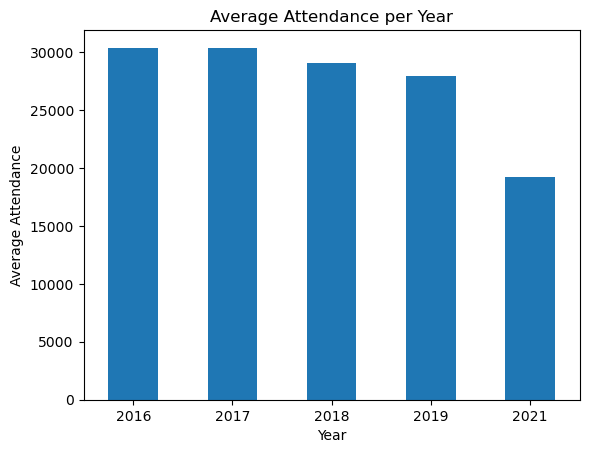

In [22]:
# import relevant library
import matplotlib.pyplot as plt

# yearly average attendance
year_avg_attendance = df.groupby('year')['attendance'].mean()
year_avg_attendance = year_avg_attendance.sort_values(ascending = False)

# plot yearly average attendance
year_avg_attendance.plot(kind = 'bar')
plt.title('Average Attendance per Year')
plt.xlabel('Year')
plt.ylabel('Average Attendance')
plt.xticks(rotation=0)  
plt.show()

**Average attendance to MLB games was lowest in 2021,** during the COVID-19 pandemic. However, there was already a downward trend in average attendance over time.

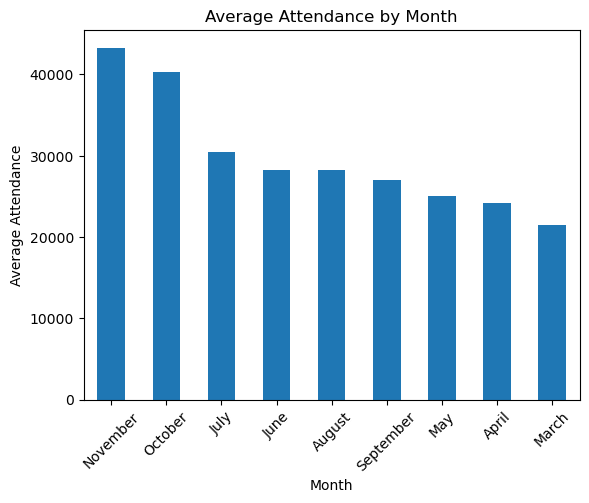

In [23]:
# monthly average attendance
month_avg = df.groupby('month')['attendance'].mean()
month_avg = month_avg.sort_values(ascending = False)

# plot monthly average attendance
month_avg.plot(kind = 'bar')
plt.title('Average Attendance by Month')
plt.xlabel('Month')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**Average attendance to MLB games was lowest at the beginning of the season in March, April, and May.** It may be the case that people don't want to attend games that don't have high stakes. **The games with the highest stakes happen in October and November, during the playoffs and this is reflected in average attendance in this dataset.** June and July have the next highest average attendance, maybe because these are Summer months, during which kids are out of schools and people may be more likely to take vacations.

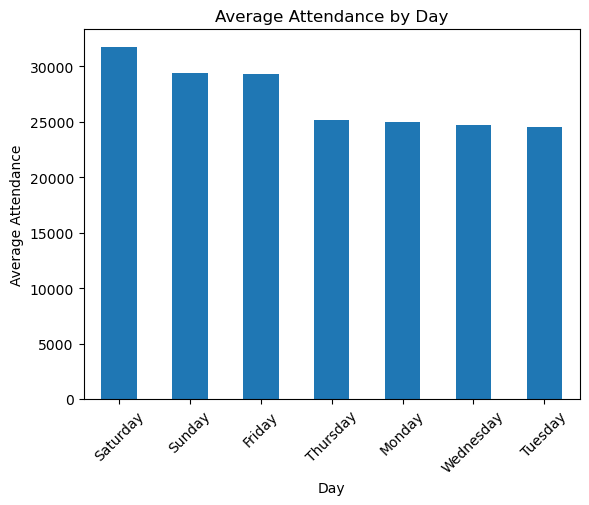

In [24]:
# daily average attendance
day_avg = df.groupby('day_of_week')['attendance'].mean()
day_avg = day_avg.sort_values(ascending = False)

# plot daily average attendance
day_avg.plot(kind = 'bar')
plt.title('Average Attendance by Day')
plt.xlabel('Day')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**As expected, average attendance was greatest during weekend days, which includes Friday, Saturday, and Sunday.** These are the days people have more free time to watch sports games. Regular weekdays (not including Friday) had similar average attendance.

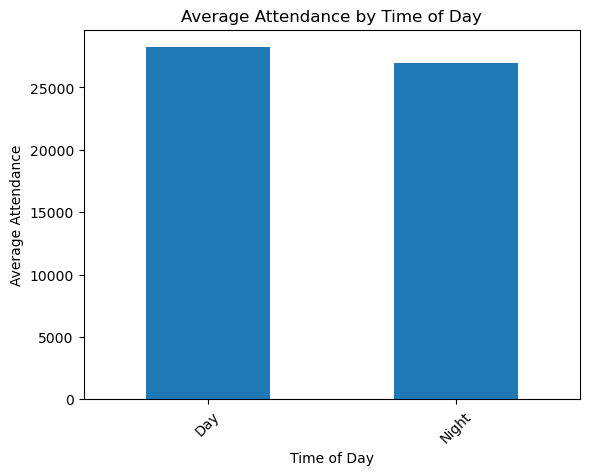

In [25]:
# average attendance by time of day
time_avg = df.groupby('time_of_day')['attendance'].mean()
time_avg = time_avg.sort_values(ascending = False)

# plot average attendance by time of day
time_avg.plot(kind = 'bar')
plt.title('Average Attendance by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**Games that occurred in the day were a bit better attended on average that games that occurred at night.** People may prefer to be at home or off the roads by nighttime. Thus, day games may be more accessible to most people.

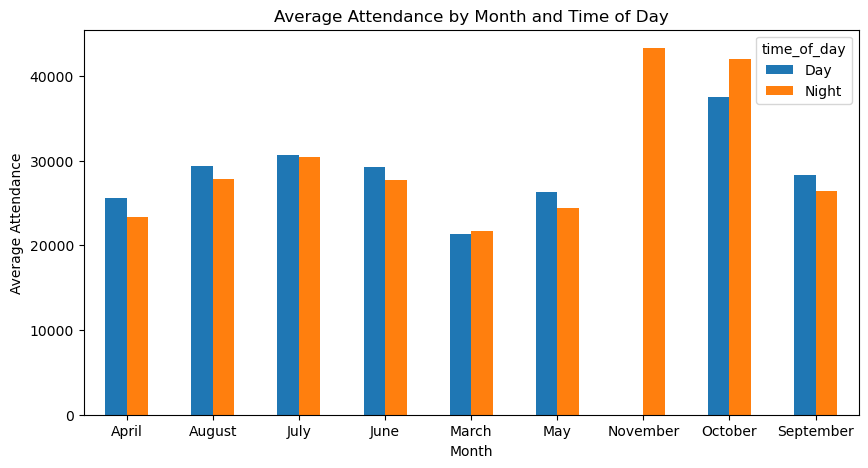

In [26]:
# average attendance by month and time of day
month_day_avg = pd.DataFrame(df.groupby(['month', 'time_of_day'])['attendance'].mean())
month_day_avg = month_day_avg.reset_index()
month_day_att = month_day_avg.pivot(index='month', columns='time_of_day', values='attendance')

# plot average attendance by month and time of day
month_day_att.plot(kind = 'bar', figsize=(10,5))
plt.title('Average Attendance by Month and Time of Day')
plt.xlabel('Month')
plt.ylabel('Average Attendance')
plt.xticks(rotation=0)  
plt.show()

When average attendance is explored by both month and time of day, we see that attendance was still lowest at the beginning of the season in March, April, and May and highest during playoffs in October and November. **However, nightime games seem to outperform daytime games during the playoffs.** In fact, there doesn't seem to be any daytime games in November in this dataset.

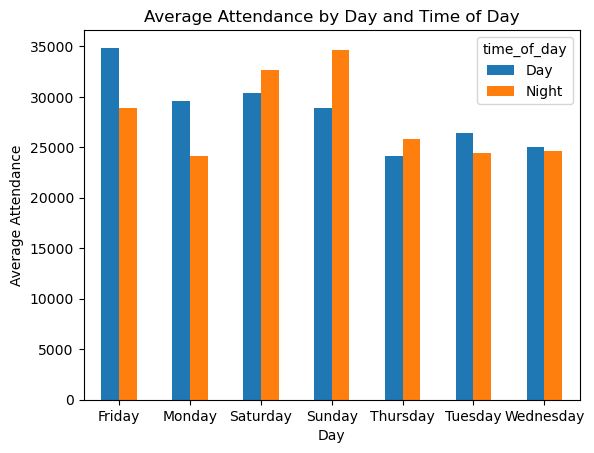

In [27]:
# average attendance by weekday and time of day
day_time_avg = pd.DataFrame(df.groupby(['day_of_week', 'time_of_day'])['attendance'].mean())
day_time_avg = day_time_avg.reset_index()
day_time_att = day_time_avg.pivot(index='day_of_week', columns='time_of_day', values='attendance')

# average attendance by weekday and time of day plotted
day_time_att.plot(kind = 'bar')
plt.title('Average Attendance by Day and Time of Day')
plt.xlabel('Day')
plt.ylabel('Average Attendance')
plt.xticks(rotation=0)  
plt.show()

**Interestingly, average attendance is greater for daytime games on Friday but greater for nightime games on Saturday and Sunday in this dataset.** On other weekdays (not including Friday), average attendance tends to be higher for daytime games.

#### Average Attendance by MLB teams

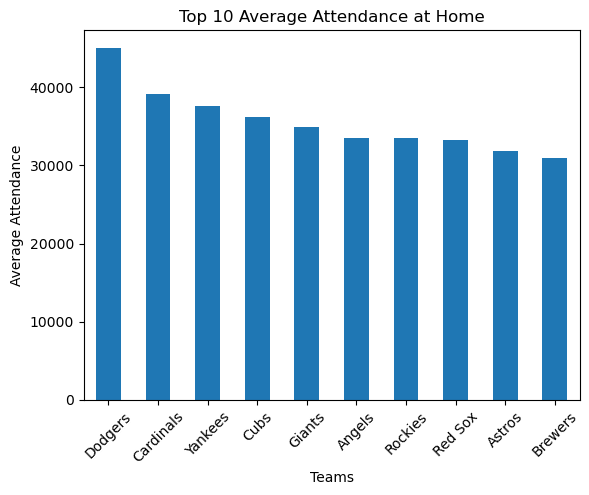

In [28]:
# which 10 teams had the highest average attendance at home
home_avg_att = df.groupby('home_team')['attendance'].mean()
home_avg_att_sorted = home_avg_att.sort_values(ascending = False).head(10)

# top 10 teams with highest average home attendance plotted
home_avg_att_sorted.plot(kind = 'bar')
plt.title('Top 10 Average Attendance at Home')
plt.xlabel('Teams')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

In line with the games that had the highest attendance in the dataset, **Dodgers home games also had the highest average attendance.** The teams with the highest average home game attendance can probably rely on greater revenue (e.g., ticket sales, concessions and merchandise, parking and premium), sponsorship and advertising leverage, and maybe even home-field advantage.

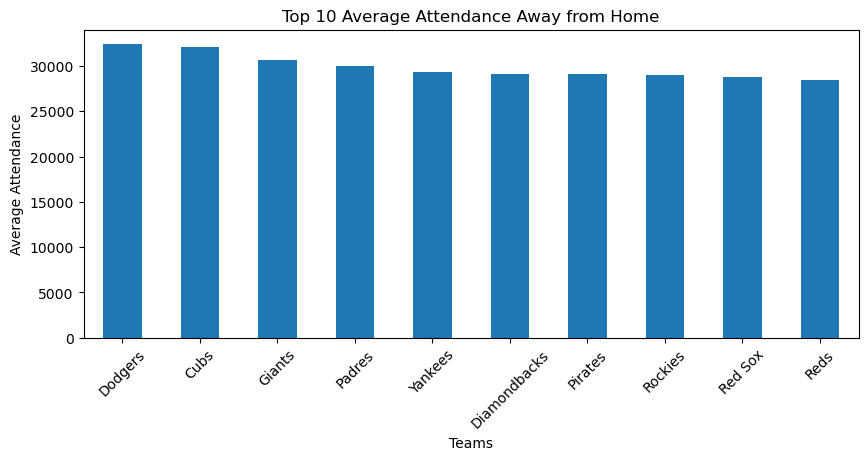

In [29]:
# which 10 teams had the highest average attendance when they were away from home
# these teams brought the crowds despite not playing at home
opponent_avg_att = df.groupby('opponent')['attendance'].mean()
opponent_avg_att_sorted = opponent_avg_att.sort_values(ascending = False).head(10)

# top 10 teams with highest average away attendance plotted
opponent_avg_att_sorted.plot(kind = 'bar', figsize=(10,4))
plt.title('Top 10 Average Attendance Away from Home')
plt.xlabel('Teams')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**It is interesting that many of the same teams that have the highest average home game attendance also draw larger crowds on average when they play in other teams' stadiums.** This indicates strong branding. These teams include the Dodgers, Cubs, Giants, Yankees, Rockies, and Red Sox. The home teams facing these opponents should be prepared for larger crowds when these clubs roll into town. Moreover, the Dodgers still draw the highest crowds on average even when they are on the road.

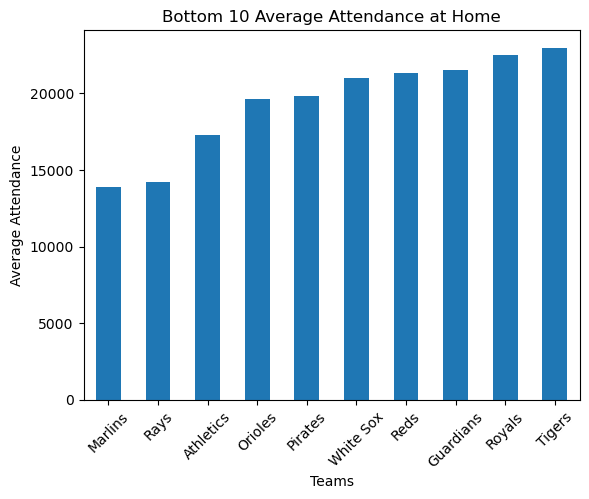

In [30]:
# which 10 teams had the lowest average attendance at home
lowest_home_att = df.groupby('home_team')['attendance'].mean()
lowest_home_att_sorted = lowest_home_att.sort_values().head(10)

# 10 teams with lowest average home attendance plotted
lowest_home_att_sorted.plot(kind = 'bar')
plt.title('Bottom 10 Average Attendance at Home')
plt.xlabel('Teams')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**The above teams had the lowest average home game attendance in this dataset, with the Marlins having the lowest of all.** These teams are probably good candidates for stadium expansion and should consider promotional efforts to increase attendance, which will likely boost revenue and sponsorships.

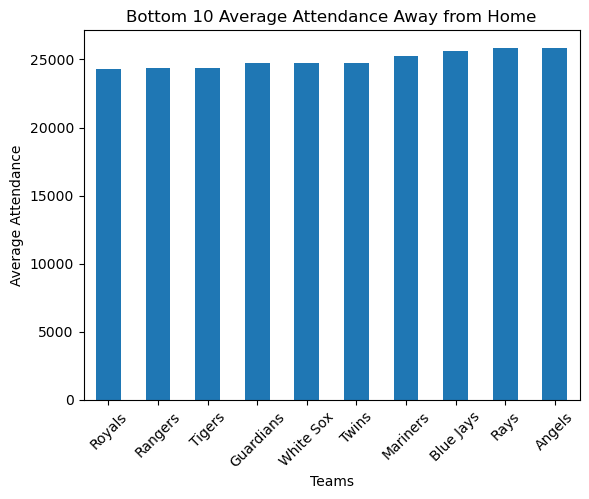

In [31]:
# which 10 teams had the lowest average attendance when they were away from home
# these teams are the ones people didn't want to see their home teams play
lowest_opponent_att = df.groupby('opponent')['attendance'].mean()
lowest_opponent_att_sorted = lowest_opponent_att.sort_values().head(10)

# 10 teams with lowest average away attendance plotted
lowest_opponent_att_sorted.plot(kind = 'bar')
plt.title('Bottom 10 Average Attendance Away from Home')
plt.xlabel('Teams')
plt.ylabel('Average Attendance')
plt.xticks(rotation=45)  
plt.show()

**Some of the same teams that have the lowest average home game attendance also draw smaller crowds on average when they play in other teams' stadiums.** This may indicate weak branding, low fan loyalty, or modest support. These teams include the Royals, Tigers, Guardians, White Sox, and Rays. The home teams facing these opponents should be prepared for average or lower turnout when these clubs roll into town.

## <span style="color:blue">XG Boost Machine Learning Model</span>

I built a XG Boost machine learning model to predict future game attendance using home team, opponent (away team), year, month, day of the week, and time of day. I chose to a XG Boost model because it is powerful and robust, avoids overfitting, handles both categorical and numerical variables well, can handle non-linear relationships, works well even when the impact of predictors is complex, and provides feature importance. XG Boost models are also easy to interpret and usually outperform basic machine learning models.

#### Import Important libraries

In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Define feature and target variables
The target variable was attendance, while the feature variables include home team, opponent (away team), year, month, day of the week, and time of day. I also numerized my feature variables so that they can be used in the XG Boost model.

In [33]:
# Define features & target
X = df.drop(columns=['attendance', 'date'])
y = df['attendance']

# Categorical columns (for one-hot encoding)
categorical_features = ['home_team', 'opponent', 'year', 'month', 'day_of_week', 'time_of_day']

# Apply one-hot encoding
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

#### Building, training, and testing the model
First, I split the data into training and test sets. The training set was 80% while the test set was 20% of the data. I then built the XG Boost model with a number of estimators of 100, a learning rate of 0.1, and maximum depth of 6. The model was trained and tested. I obtained model performance statistics including mean absolute error, mean square error, and root mean square error to evaluate the average difference between the attendance predicted by the model and actual attendance in the test dataset. I also obtained R^2 to understand how much of the variance in attendance was explained by the model.

In [34]:
# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))]
                )

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error: {round(MAE,2)}")
print(f"Root Mean Squared Error: {round(RMSE,2)}")
print(f"R² Score: {r2_score(y_test, y_pred)}")

print(f'Mean Y_Test: {round(y_test.mean(), 2)}')
print(f'Standard Deviation Y_Test: {round(y_test.std(), 2)}')

Mean Absolute Error: 3870.87
Root Mean Squared Error: 5091.77
R² Score: 0.8028192217503182
Mean Y_Test: 27364.11
Standard Deviation Y_Test: 11468.96


**The model performed relatively well** with an average difference between predicted and actual values (MAE) of 3,871 and a RMSE (square root of the average of squared differences between predicted and actual values) of 5,092. The MAE OF around 3,900 and the RMSE of around 5,000 are relatively small values given the mean and standard deviation of attendance in the test dataset were around 27,364 and 11,469 respectively. The model also explained around 80% of the variance in attendance in the test dataset.

#### Comparing actual and model-predicted attendance
I created a table and a figure to compare the actual attendance in the test data and the model-predicted attendance. They show that there are both large and small differences in these figures. However, there is a strong positive correlation between the values.

In [35]:
# Create a DataFrame comparing actual and predicted values
results_df = pd.DataFrame({'Actual Attendance': y_test.values, 'Predicted Attendance': y_pred})
results_df.head(10)

,Actual Attendance,Predicted Attendance
0,30137,31016.876953
1,38673,40245.242188
2,14390,18224.310547
3,31509,25728.271484
4,29117,25462.646484
5,24259,23403.777344
6,11436,19256.160156
7,33082,33005.820312
8,32811,35387.453125
9,15483,23076.455078


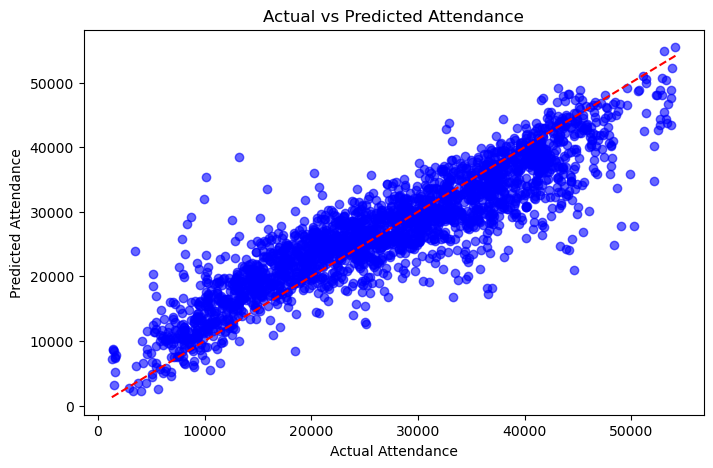

In [36]:
# Create a scatterplot of actual and predicted attendance in the model test data
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Reference line
plt.xlabel("Actual Attendance")
plt.ylabel("Predicted Attendance")
plt.title("Actual vs Predicted Attendance")
plt.show()

In [37]:
# The correlation between actual and predicted attendance in the model test data
results_df['Actual Attendance'].corr(results_df['Predicted Attendance'])

0.9017724431612502

#### Predicting Future Game Attendance
I put the model to the test by having it predict two future games.

In [38]:
future_game = pd.DataFrame({
    'home_team': ['Astros', 'Yankees'],
    'opponent': ['Red Sox', 'Rangers'],
    'year': ['2023', '2022'],
    'month': ['August', 'May'],
    'day_of_week': ['Monday', 'Sunday'],
    'time_of_day': ['Night', 'Night'],
})

# Predict attendance
predicted_attendance = model.predict(future_game)
print(f"Predicted attendance for Astros (home) vs. Red Sox on Friday night, April 21, 2023: {predicted_attendance[0]} \n vs. actual attedance from espn.com: 31,590")
# https://www.espn.com/mlb/game/_/gameId/401472887/red-sox-astros
print(f"Predicted attendance for Yankees (home) vs. Rangers on Sunday night, May 8, 2022: {predicted_attendance[1]} \n vs. actual attedance from baseball-reference.com: 40,714")
# https://www.baseball-reference.com/boxes/NYA/NYA202205082.shtml

Predicted attendance for Astros (home) vs. Red Sox on Friday night, April 21, 2023: 30201.173828125 
 vs. actual attedance from espn.com: 31,590
Predicted attendance for Yankees (home) vs. Rangers on Sunday night, May 8, 2022: 39353.76953125 
 vs. actual attedance from baseball-reference.com: 40,714


The model ended up being pretty accurate for the 2 future games it predicted, despite the games being in 2022, and 2023.

#### Important features/variables
I obtained the variables/features that were most important for the model or the factors that were the best predictors of attendance for the model. I created a dataframe which included the top 10 features in order of importance for the XG Boost model.

In [39]:
# Get feature names after preprocessing
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from XGBoost
importance = model.named_steps['regressor'].feature_importances_

# Create a DataFrame of feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the top features
feature_importance.head(10)

,Feature,Importance
9,cat__home_team_Dodgers,0.106367
6,cat__home_team_Cardinals,0.068512
29,cat__home_team_Yankees,0.057945
21,cat__home_team_Rays,0.057784
13,cat__home_team_Marlins,0.051390
7,cat__home_team_Cubs,0.046050
64,cat__year_2021,0.043871
2,cat__home_team_Athletics,0.040553
10,cat__home_team_Giants,0.038104
28,cat__home_team_White Sox,0.030562


The most important predictor of attendance in the XG Boost model was the **home team**. Particularly, whether the Dodgers, Cardinals, Yankees, Rays, Marlins, or Cubs were the home teams was very important for the model's prediction. Interestingly, our exploratory data analysis (EDA) showed that the Dodgers, Cardinals, Yankees, and Cubs had the highest average home attendance in our dataset, while the Marlins and Rays had the lowest average home attendance. Another important predictor of attedance in the model was **year** and particularly, the year 2021. As our EDA also showed, 2021 had the lowest average attendance -- probabaly due to the COVID-19 pandemic.

## <span style="color:blue">Conclusions</span>

- **My analysis showed that the most important factor in MLB game attendance was the home team, likely due to differences in stadium capacity.** The Dodgers, Cardinals, Yankees, and Cubs had the highest average home attendance, while the Marlins and Rays had the lowest average home attendance.
- **Teams with the highest average home game attendance can probably increase revenue by pricing merchandise and tickets higher for games that are predicted to have high attendance.** Many of these teams also draw larger crowds when they play in other stadiums. The home teams facing these opponents should be prepared for larger crowds when these clubs roll into town.
- **Teams with lower average home game attendance are probably good candidates for stadium expansion and should consider promotional efforts to increase attendance and boost revenue and sponsorships.** Some of these teams also draw smaller crowds when they play in other stadiums. This may indicate weak branding, low fan loyalty, or modest support.
- **The MLB should probably schedule teams with higher average attendance during the weekend, with daytime games on Friday and night games on Saturday and Sunday to boost revenue. In the playoffs, more night games should be scheduled to take advantage of higher average attendance during this time of day in October and November.**
- **International MLB games at high-capacity stadiums and between well-known teams may draw large crowds and further strengthen the teams' and MLB's brand overseas.**

## <span style="color:blue">Next Steps</span>

- Other variables may affect the attendance of MLB games, including **weather, holidays, team performance, opponent strength, ticket price, and most importantly, stadium capacity.** These variables should be explored in relation to game attendance as they may increase the accuracy of predicted attendance for future MLB games.
- **Further analyses should explore whether teams with greater average home attendance tend win more games when they are at home compared to when they are on the road and compared to teams with smaller home attendance.** The results of this examination may provide an incentive for stadium expansion for teams with lower average home game attendance.